### Setup

In [59]:
import xarray as xr
from pathlib import Path
import numpy as np
import yaml
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from matplotlib import colormaps


# set up paths
this_dir = Path("/glade/u/home/jmelms/projects/dcmip2025_idealized_tests/experiments/mass_conservation")
model_output_path = this_dir / "data" / "raw_output.nc"
plot_dir = this_dir / "plots"
plot_dir.mkdir(parents=True, exist_ok=True)


# read configuration
config_path = this_dir / "0.config.yaml"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

ic_dates = [dt.datetime.strptime(str_date, "%Y/%m/%d %H:%M") for str_date in config["ic_dates"]]
n_ics = len(ic_dates)
n_timesteps = config["n_timesteps"]


### set these variables
config_str = "/glade/work/jmelms/data/dcmip2025_idealized_tests/experiments/long_sim_0/config.yml"
cmap_str = "viridis" # options here: matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = colormaps.get_cmap(cmap_str)

ic_colors = cmap(np.linspace(0, 1, n_ics))
units_table = {
    "VAR_2T": "K",
    "VAR_10U": "m/s",
    "VAR_10V": "m/s",
    "VAR_100U": "m/s",
    "VAR_100V": "m/s",
    "VAR_500T": "K",
    "T": "K",
    "U": "m/s",
    "V": "m/s",
    "Z": "m",
    "R": "%",
    "SP": "hPa",
    "MSL": "hPa",
    "TCW": "kg/m^2",
    "Q": "kg/kg",
    "total_energy": "J/m^2",
    "lw_te": "J/m^2",
    "dte_dt": "W/m^2",
}

# define consts
cp = 1005.0  # J/kg/K
g = 9.81  # m/s^2j
Lv = 2.26e6  # J/kg

### calculate some latitude-weighted global mean quantities
def latitude_weighted_mean(da, latitudes):
    """
    Calculate the latitude weighted mean of a variable in a dataset
    """
    lat_radians = np.deg2rad(latitudes)
    weights = np.cos(lat_radians)
    weights.name = "weights"
    var_weighted = da.weighted(weights)
    return var_weighted.mean(dim=["latitude", "longitude"])

print(f"Loading data from {model_output_path}")

Loading data from /glade/u/home/jmelms/projects/dcmip2025_idealized_tests/experiments/mass_conservation/data/raw_output.nc


### Retrieve and calculate ERA5 pressure for the same intervals

In [50]:
# path to the ERA5 pressure data
e5_base = "/glade/campaign/collections/rda/data/ds633.0/"
sp_template = f"{e5_base}/e5.oper.an.sfc/{{year:04}}{{month:02}}/e5.oper.an.sfc.128_134_sp.ll025sc.{{year:04}}{{month:02}}0100_{{year:04}}{{month:02}}{{dayend:02}}23.nc"
sp_dict = {}
for time in ic_dates:
    keep_times = time + dt.timedelta(hours=6) * np.arange(n_timesteps+1)
    dayend = calendar.monthrange(time.year, time.month)[1]
    assert keep_times[-1] <= dt.datetime(time.year, time.month, dayend, 23, 0), "Haven't implemented multi-month data yet, try an earlier day or shorter inference"
    sp_file = sp_template.format(year=time.year, month=time.month, dayend=dayend)
    sp_ds = xr.open_dataset(sp_file)
    sp_ds = sp_ds.sel(time=keep_times).squeeze()
    sp_dict[time] = latitude_weighted_mean(sp_ds["SP"], sp_ds["latitude"]) / 100 # convert to hPa
    print(f"Loaded {sp_file} for {time} with shape {sp_ds['SP'].shape}")
    
sp_dict[time]

Loaded /glade/campaign/collections/rda/data/ds633.0//e5.oper.an.sfc/201801/e5.oper.an.sfc.128_134_sp.ll025sc.2018010100_2018013123.nc for 2018-01-01 12:00:00 with shape (29, 721, 1440)
Loaded /glade/campaign/collections/rda/data/ds633.0//e5.oper.an.sfc/201807/e5.oper.an.sfc.128_134_sp.ll025sc.2018070100_2018073123.nc for 2018-07-01 12:00:00 with shape (29, 721, 1440)
Loaded /glade/campaign/collections/rda/data/ds633.0//e5.oper.an.sfc/202001/e5.oper.an.sfc.128_134_sp.ll025sc.2020010100_2020013123.nc for 2020-01-01 12:00:00 with shape (29, 721, 1440)
Loaded /glade/campaign/collections/rda/data/ds633.0//e5.oper.an.sfc/202007/e5.oper.an.sfc.128_134_sp.ll025sc.2020070100_2020073123.nc for 2020-07-01 12:00:00 with shape (29, 721, 1440)
Loaded /glade/campaign/collections/rda/data/ds633.0//e5.oper.an.sfc/202201/e5.oper.an.sfc.128_134_sp.ll025sc.2022010100_2022013123.nc for 2022-01-01 12:00:00 with shape (29, 721, 1440)
Loaded /glade/campaign/collections/rda/data/ds633.0//e5.oper.an.sfc/202207/

<xarray.DataArray 'SP' (time: 29)> Size: 232B
array([985.95394349, 985.95565926, 985.94672852, 985.94726049,
       985.94926718, 985.95008176, 985.93941757, 985.93920027,
       985.9595502 , 985.96101009, 985.95410205, 985.95464286,
       985.96523436, 985.96551004, 985.95369989, 985.95464166,
       985.97573564, 985.9764672 , 985.98126119, 985.98172131,
       985.97211405, 985.97316277, 985.95639383, 985.95696524,
       985.96944757, 985.96987302, 985.94261942, 985.94303791,
       985.96179058])
Coordinates:
  * time     (time) datetime64[ns] 232B 2022-07-01T12:00:00 ... 2022-07-08T12...

### Load and Process Data

In [51]:
# load dataset -- this might be very large, so be careful
ds = xr.open_dataset(model_output_path).squeeze()  # data only has one member

# convert SP and MSL from Pa to hPa
ds["SP"] = ds["SP"] / 100
ds["MSL"] = ds["MSL"] / 100

# reset time coordinate
time_hours = (ds.time - ds.time[0]) / np.timedelta64(
    1, "h"
)  # set time coord relative to start time
ds.update({"time": time_hours})
ds = ds.assign_attrs({"time units": "hours since start"})

ds["mean_SP"] = latitude_weighted_mean(ds["SP"], ds.latitude)
ds["ens_mean_SP"] = ds["mean_SP"].mean(dim="init_time")


### Plot change in pressure over time

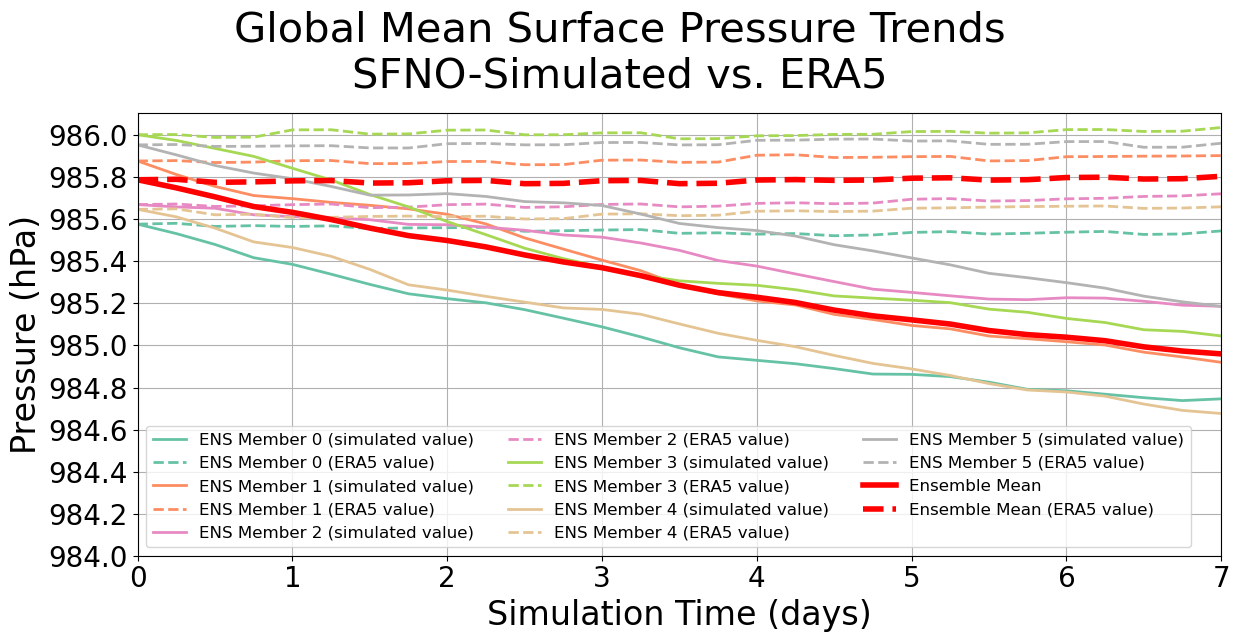

In [69]:
# Plot the results
plot_var = "mean_SP"
title = "Global Mean Surface Pressure Trends\nSFNO-Simulated vs. ERA5"
linewidth = 2
fontsize = 24
smallsize = 20
cmap = colormaps.get_cmap("Set2")
qual_colors = cmap(np.linspace(0, 1, n_ics))

fig, ax = plt.subplots(figsize=(12.5, 6.5))
sp_mems = ds[plot_var]
for i, ic in enumerate(ic_dates):
    linedat = sp_mems.isel(init_time=i)
    color = qual_colors[i]
    ax.plot(time_hours, linedat, color=color, linewidth=linewidth, label=f"ENS Member {i} (simulated value)")
    ax.plot(time_hours, sp_dict[ic], color=color, linewidth=linewidth, label=f"ENS Member {i} (ERA5 value)", linestyle="--")
    
sp_ens = ds["ens_mean_SP"]
ax.plot(time_hours, sp_ens, color="red", linewidth=2*linewidth, label="Ensemble Mean", linestyle="-")
sp_dict["mean"] = np.array([sp_dict[ic] for ic in ic_dates]).mean(axis=0)
ax.plot(time_hours, sp_dict["mean"], color="red", linewidth=2*linewidth, label="Ensemble Mean (ERA5 value)", linestyle="--")
   
ax.set_xticks(time_hours[::4], (time_hours[::4]/24).values.astype("int"), fontsize=smallsize)
yticks = np.linspace(984, 986, 11)
ax.set_yticks(yticks, yticks, fontsize=smallsize)
ax.set_xlabel("Simulation Time (days)", fontsize=fontsize)
ax.set_ylabel("Pressure (hPa)", fontsize=fontsize)
ax.set_xlim(xmin=0, xmax=time_hours[-1])
fig.suptitle(title, fontsize=30)
ax.grid()
ax.set_facecolor("#ffffff")
fig.tight_layout()
plt.legend(fontsize=12, loc="lower left", ncols=3)
plt.savefig(plot_dir / f"{title}.png", dpi=300, bbox_inches="tight")